In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [6]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total

    # Validation/Test
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = correct / total

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Test Acc: {test_acc*100:.2f}%")

Epoch 1/50, Loss: 239.5603, Train Acc: 89.38%, Test Acc: 85.27%
Epoch 2/50, Loss: 244.4328, Train Acc: 89.22%, Test Acc: 86.19%
Epoch 3/50, Loss: 239.6918, Train Acc: 89.44%, Test Acc: 85.96%
Epoch 4/50, Loss: 242.0298, Train Acc: 89.23%, Test Acc: 86.07%
Epoch 5/50, Loss: 238.6744, Train Acc: 89.43%, Test Acc: 85.92%
Epoch 6/50, Loss: 244.7159, Train Acc: 89.32%, Test Acc: 85.95%
Epoch 7/50, Loss: 239.1781, Train Acc: 89.36%, Test Acc: 85.96%
Epoch 8/50, Loss: 237.0088, Train Acc: 89.47%, Test Acc: 86.25%
Epoch 9/50, Loss: 236.5893, Train Acc: 89.47%, Test Acc: 86.50%
Epoch 10/50, Loss: 238.0374, Train Acc: 89.27%, Test Acc: 85.80%
Epoch 11/50, Loss: 237.8035, Train Acc: 89.33%, Test Acc: 85.90%
Epoch 12/50, Loss: 233.3073, Train Acc: 89.56%, Test Acc: 85.84%
Epoch 13/50, Loss: 228.4248, Train Acc: 89.84%, Test Acc: 85.95%
Epoch 14/50, Loss: 236.7848, Train Acc: 89.40%, Test Acc: 86.03%
Epoch 15/50, Loss: 235.4427, Train Acc: 89.41%, Test Acc: 86.35%
Epoch 16/50, Loss: 229.5314, Train

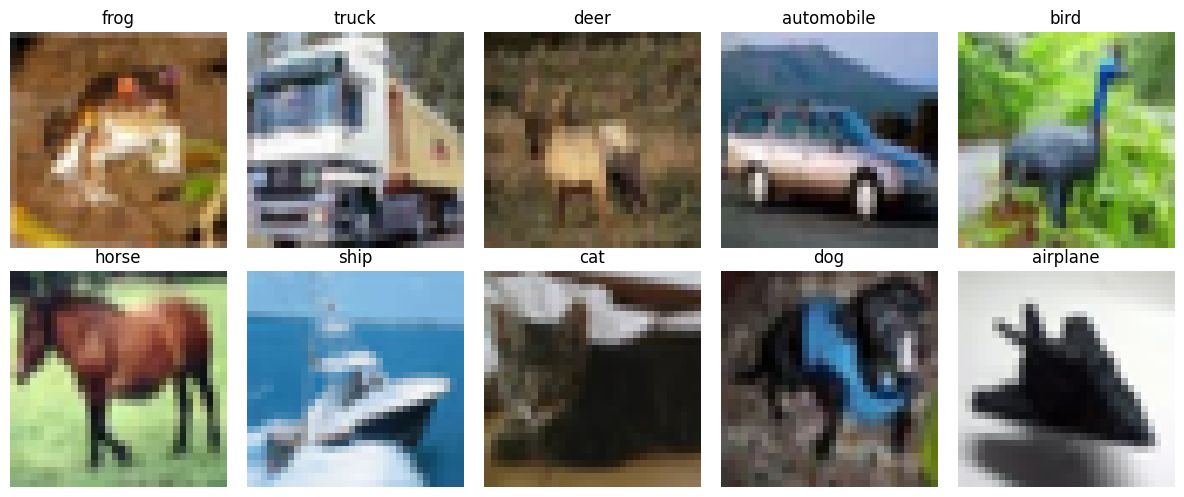

In [11]:
# CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Find one image per class
images_per_class = {}
for img, label in dataset:
    if label not in images_per_class:
        images_per_class[label] = img
    if len(images_per_class) == 10:
        break

# Plot the images
plt.figure(figsize=(12, 5))
for idx, (label, img) in enumerate(images_per_class.items()):
    np_img = img.numpy().transpose((1, 2, 0))
    plt.subplot(2, 5, idx + 1)
    plt.imshow(np_img)
    plt.title(classes[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
from torchsummary import summary
summary(model, (3, 32, 32))  # Input size for CIFAR-10 images (3 channels, 32x32 size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
       BatchNorm2d-8            [-1, 128, 8, 8]             256
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Linear-10                  [-1, 512]       1,049,088
          Dropout-11                  [-1, 512]               0
           Linear-12                   [-1, 10]           5,130
Total params: 1,147,914
Trainable params: 1,147,914
Non-trainable params: 0
---------------------------

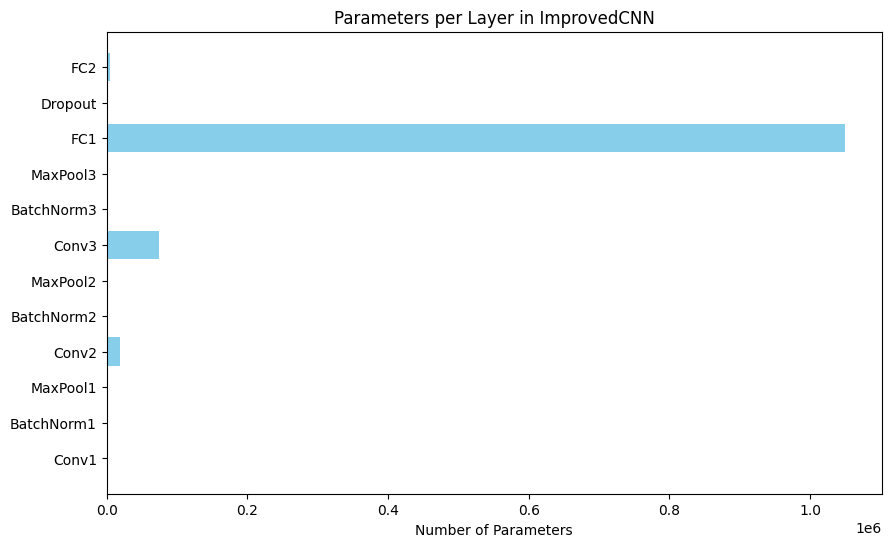

In [16]:
import matplotlib.pyplot as plt

# Layer names and corresponding parameters from the model summary
layers = [
    "Conv1", "BatchNorm1", "MaxPool1",
    "Conv2", "BatchNorm2", "MaxPool2",
    "Conv3", "BatchNorm3", "MaxPool3",
    "FC1", "Dropout", "FC2"
]

params = [
    896, 64, 0,      # Conv1, BatchNorm1, MaxPool1
    18496, 128, 0,   # Conv2, BatchNorm2, MaxPool2
    73856, 256, 0,   # Conv3, BatchNorm3, MaxPool3
    1049088, 0, 5130  # FC1, Dropout, FC2
]

# Create bar chart
plt.figure(figsize=(10, 6))
plt.barh(layers, params, color='skyblue')
plt.xlabel('Number of Parameters')
plt.title('Parameters per Layer in ImprovedCNN')
plt.show()